# ATSC 500 Final Project - WRF Simulation and Post-processing

## Introduction

The numeric model applied in the study is WRF version 3.7.1. The simulation has a 24-hour forecast horizon with hourly output and initialized by *Global Forecast System (GFS)* data at 0:00 UTC time. The PBL scheme of the model is *Grenier–Bretherton–McCaa (GBM)*. The simulation has 4 nested domains, from which the second nested domain with a 12-km grid spacing well covers the BC Province.

This notebook explains the way to match the WRF output with the CALIPSO lidar footprints. The following variables are selected and post-processed in this notebook:

```
dimensions:
	Time = UNLIMITED ; // (1 currently)
	DateStrLen = 19 ;
	west_east = 198 ;
	south_north = 228 ;
	bottom_top = 40 ;

char Times(Time, DateStrLen) ;

float XLAT(Time, south_north, west_east) ;
	  XLAT:FieldType = 104 ;
	  XLAT:MemoryOrder = "XY " ;
	  XLAT:description = "LATITUDE, SOUTH IS NEGATIVE" ;
	  XLAT:units = "degree_north" ;
	  XLAT:stagger = "" ;
	  XLAT:coordinates = "XLONG XLAT" ;
        
float XLONG(Time, south_north, west_east) ;
	  XLONG:FieldType = 104 ;
	  XLONG:MemoryOrder = "XY " ;
	  XLONG:description = "LONGITUDE, WEST IS NEGATIVE" ;
	  XLONG:units = "degree_east" ;
	  XLONG:stagger = "" ;
	  XLONG:coordinates = "XLONG XLAT" ;
        
float HGT(Time, south_north, west_east) ;
	  HGT:FieldType = 104 ;
	  HGT:MemoryOrder = "XY " ;
	  HGT:description = "Terrain Height" ;
	  HGT:units = "m" ;
	  HGT:stagger = "" ;
	  HGT:coordinates = "XLONG XLAT XTIME" ;
        
float PBLH(Time, south_north, west_east) ;
	  PBLH:FieldType = 104 ;
	  PBLH:MemoryOrder = "XY " ;
	  PBLH:description = "PBL HEIGHT" ;
	  PBLH:units = "m" ;
	  PBLH:stagger = "" ;
	  PBLH:coordinates = "XLONG XLAT XTIME" ;        
```


In [2]:
from sys import path
path.insert(0, '_libs/')

In [3]:
import numpy as np
import netCDF4 as nc
from glob import glob
import CALIPSO_lib as Clib

In [5]:
wrfdir = '/Users/yingkai/Google Drive File Stream/My Drive/Model_restored_backup/'
nc_obj = nc.Dataset(wrfdir+'15111300/wrfout_d02_2015-11-13_06:00:00')
XLAT = nc_obj.variables['XLAT'][0, ...]
XLONG = nc_obj.variables['XLONG'][0, ...]
nc_obj.close()
# CALIPSO data in Part I
cal_obj = nc.Dataset('_data/ATSC-500/CALIPSO_CBL_Retrieval.nc')
z = cal_obj.variables['z'][:]
groups = cal_obj.variables['group_keys'][:]

In [7]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.lines as mlines
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline
# Load lat/lon in BC
TEMP_obj = np.load('_data/ATSC-500/BC_Boundary.npy', encoding='latin1')
BC_lon = TEMP_obj[()]['BC_lon']
BC_lat = TEMP_obj[()]['BC_lat']
BC_polygon = Path(list(zip(BC_lon, BC_lat)))

## Research area

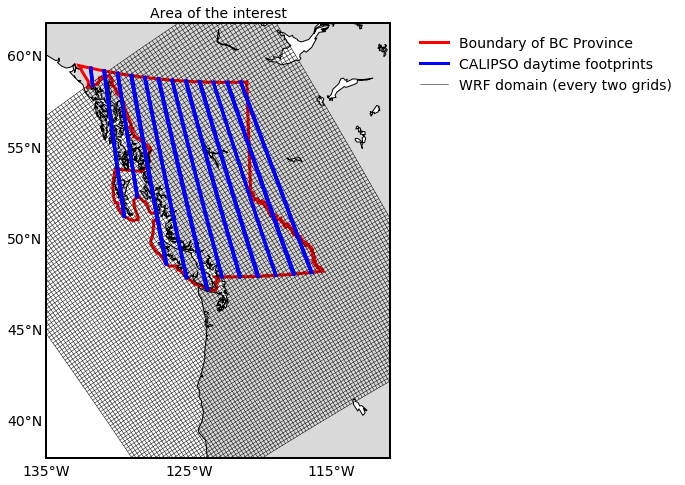

In [10]:
fig = plt.figure(figsize=(8, 8)); ax = fig.gca()
ax.set_title('Area of the interest', fontsize=14)
[i.set_linewidth(2.0) for i in ax.spines.values()]
proj = Basemap(projection='lcc', area_thresh=1000, lat_0=53, lon_0=-122.5, 
               llcrnrlat=38, urcrnrlat=62, llcrnrlon=-135, urcrnrlon=-102.5, resolution='l', ax=ax)
proj.drawcoastlines(linewidth=1.0, color='k')
proj.fillcontinents(color='.85', lake_color='w')
proj.drawparallels(np.arange(-90, 90, 5), labels=[1, 0, 0, 0], fontsize=14, latmax=90, linewidth=0)
proj.drawmeridians(np.arange(-135, 180, 10), labels=[0, 0, 0, 1], fontsize=14, latmax=90, linewidth=0)
BC_x, BC_y = proj(BC_lon, BC_lat)
BC_poly_map = patches.Polygon(np.vstack([BC_x, BC_y]).T, hatch='', fc='none', ec='r', lw=3.0)
ax.add_patch(BC_poly_map)
gridx, gridy = proj(XLONG, XLAT)
proj.plot(gridx[::2, ::2], gridy[::2, ::2], 'k-', lw=0.5);
proj.plot(gridx[::2, ::2].T, gridy[::2, ::2].T, 'k-', lw=0.5);
for group in groups:
    temp_group = cal_obj.groups[group]
    cal_lon = temp_group.variables['Longitude'][:]
    cal_lat = temp_group.variables['Latitude'][:]
    calx, caly = proj(cal_lon, cal_lat)
    proj.plot(calx, caly, 'b-', lw=3.0)
# fake legend
L1 = mlines.Line2D([], [], color='r', lw=3.0, label='Boundary of BC Province')
L2 = mlines.Line2D([], [], color='b', lw=3.0, label='CALIPSO daytime footprints')
L3 = mlines.Line2D([], [], color='k', lw=0.5, label='WRF domain (every two grids)')
LG = ax.legend(handles=[L1, L2, L3], bbox_to_anchor=(1.05, 1), prop={'size':14}); LG.draw_frame(False)

Approximatly 11 repeated footprints fall into the model domain in BC. The resolution of the profile is 1/3 km, higher than the model grid spacing, thus for each of the lidar profile, model output is interpolated onto its track. The interpolation is based on `scipy.interpolate.griddata`.

```python
def grid_transfer(raw_x, raw_y, raw_data, nav_lon, nav_lat, method='linear'):
    LatLonPair=(raw_x.flatten(), raw_y.flatten())
    data_interp = griddata(LatLonPair, raw_data.flatten(), (nav_lon, nav_lat), method=method)
    return data_interp
```

Comparing with the speed of satellite, the time change for each of the profile within BC is negletable. The closest hourly model output is used to match with the lidar profile (e.g. lidar profile at 0:30 will be matched with the simulate at 1:00 on the same day).

```python
from os.path import exists
cal_CBL_store = np.zeros(0)
cal_HGT_store = np.zeros(0)
interp_CBL_store = np.zeros(0)
interp_HGT_store = np.zeros(0)
# combining all the available CBL height records
for i, group in enumerate(groups):
    temp_group = cal_obj.groups[group]
    cal_CBL = temp_group.variables['CBL_H'][:]
    cal_lat = temp_group.variables['Latitude'][:]
    cal_lon = temp_group.variables['Longitude'][:]
    cal_elev = temp_group.variables['Elevation'][:]
    cal_time = temp_group.variables['Time_UTC'][:].mean()
    filename = Clib.get_wrf_dir(wrfdir, Clib.CALIPSO_to_datetime(cal_time))
    if exists(filename):
        #print(filename)
        nc_obj = nc.Dataset(filename)
        wrf_HGT = nc_obj.variables['HGT'][0, ...]*1e-3
        wrf_CBL = nc_obj.variables['PBLH'][0, ...]*1e-3 # m to km
        wrf_lat = nc_obj.variables['XLAT'][0, ...]
        wrf_lon = nc_obj.variables['XLONG'][0, ...]
        nc_obj.close()
        interp_CBL = Clib.grid_transfer(wrf_lon, wrf_lat, wrf_CBL, cal_lon, cal_lat, method='linear')
        interp_HGT = Clib.grid_transfer(wrf_lon, wrf_lat, wrf_HGT, cal_lon, cal_lat, method='linear')
        good_flag = np.logical_and(~np.isnan(cal_CBL), ~np.isnan(interp_CBL))
        cal_CBL_store = np.hstack([cal_CBL_store, cal_CBL[good_flag]])
        cal_HGT_store = np.hstack([cal_HGT_store, cal_elev[good_flag]])        
        interp_CBL_store = np.hstack([interp_CBL_store, interp_CBL[good_flag]])
        interp_HGT_store = np.hstack([interp_HGT_store, interp_HGT[good_flag]])
# new file to store the combined data and four example profiles
new_obj = nc.Dataset('_data/ATSC-500/CBL_Comparison.nc', 'w', format='NETCDF4') 
group_keys = []
# Four profiles as example
good_ind = [4, 9, 10, 11]
for i, group in enumerate(groups[good_ind]):
    group_keys.append(group)
    temp_group = cal_obj.groups[group]
    cal_CBL = temp_group.variables['CBL_H'][:]
    cal_beta = temp_group.variables['TAB532'][:]
    cal_lat = temp_group.variables['Latitude'][:]
    cal_lon = temp_group.variables['Longitude'][:]
    cal_elev = temp_group.variables['Elevation'][:]
    cal_time = temp_group.variables['Time_UTC'][:].mean()
    filename = Clib.get_wrf_dir(wrfdir, Clib.CALIPSO_to_datetime(cal_time))
    if exists(filename):
        #print(filename)
        nc_obj = nc.Dataset(filename)
        wrf_HGT = nc_obj.variables['HGT'][0, ...]*1e-3
        wrf_CBL = nc_obj.variables['PBLH'][0, ...]*1e-3 # m to km
        wrf_lat = nc_obj.variables['XLAT'][0, ...]
        wrf_lon = nc_obj.variables['XLONG'][0, ...]
        nc_obj.close()
        interp_CBL = Clib.grid_transfer(wrf_lon, wrf_lat, wrf_CBL, cal_lon, cal_lat, method='linear')
        interp_HGT = Clib.grid_transfer(wrf_lon, wrf_lat, wrf_HGT, cal_lon, cal_lat, method='linear')
    new_group = new_obj.createGroup(group)
    new_group.createDimension('X', len(cal_lon))
    new_group.createDimension('H', len(z))
    CBL_nc = new_group.createVariable('CBL_H', np.float64, ('X',), zlib=True)
    lat_nc = new_group.createVariable('Latitude', np.float64, ('X',), zlib=True)
    lon_nc = new_group.createVariable('Longitude', np.float64, ('X',), zlib=True)
    time_nc = new_group.createVariable('Time_UTC', np.float64, ('X',), zlib=True)
    elev_nc = new_group.createVariable('Elevation', np.float64, ('X',), zlib=True)
    CBL_wrf_nc = new_group.createVariable('CBL_WRF', np.float64, ('X',), zlib=True)
    HGT_wrf_nc = new_group.createVariable('HGT_WRF', np.float64, ('X',), zlib=True)
    Beta532_nc = new_group.createVariable('TAB532', np.float64, ('X','H'), zlib=True)
    lat_nc[:] = cal_lat; lon_nc[:] = cal_lon
    CBL_nc[:] = cal_CBL; elev_nc[:] = cal_elev
    HGT_wrf_nc[:] = interp_HGT
    CBL_wrf_nc[:] = interp_CBL+interp_HGT
    time_nc[:] = temp_group.variables['Time_UTC'][:]
    Beta532_nc[:] = cal_beta
new_obj.createDimension('keyLen', len(group_keys))
gpkeys_nc = new_obj.createVariable('group_keys', '<U21', ('keyLen',))
gpkeys_nc[:] = np.array(group_keys)
# save z coord
new_obj.createDimension('H', len(z))
z_nc = new_obj.createVariable('z', np.float64, ('H',))
z_nc[:] = z
# save comparison vars
new_obj.createDimension('L', len(cal_CBL_store))
cal_CBL_nc = new_obj.createVariable('CALIPSO_CBL', np.float64, ('L',))
cal_HGT_nc = new_obj.createVariable('CALIPSO_HGT', np.float64, ('L',))
wrf_CBL_nc = new_obj.createVariable('WRF_CBL', np.float64, ('L',))
wrf_HGT_nc = new_obj.createVariable('WRF_HGT', np.float64, ('L',))
cal_HGT_nc[:] = cal_HGT_store
cal_CBL_nc[:] = cal_CBL_store
wrf_HGT_nc[:] = interp_HGT_store
wrf_CBL_nc[:] = interp_CBL_store+interp_HGT_store
new_obj.close()
```